In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as pltcm
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
import seaborn as sns
import gc

In [2]:
ord_prior =  pd.read_csv('ord_prior_we_want.csv')
ord_train = pd.read_csv('order_products__train.csv')
ord_test = pd.read_csv('ord_prior_we_dont_want.csv')
orders =  pd.read_csv('orders_no_test.csv')
product = pd.read_csv('products.csv')
department = pd.read_csv('departments.csv')
aisles = pd.read_csv('aisles.csv')

In [3]:
orders_product = pd.merge(ord_prior, orders, how='inner', on='order_id')
train_orders = pd.merge(ord_train, orders[['order_id','user_id']], how='inner', on='order_id')

In [4]:
prd = orders_product.sort_values(['user_id', 'order_number', 'product_id'], ascending=True)
prd['product_time'] = prd.groupby(['user_id', 'product_id']).cumcount()

prd_first = prd[prd['product_time'] == 0].groupby('product_id').size().to_frame('prod_first_orders') #每個產品被第一次訂購的數量
prd_second = prd[prd['product_time'] == 1].groupby('product_id').size().to_frame('prod_second_orders') #每個產品被第二次訂購的數量
prd_first['prod_orders'] = prd.groupby('product_id')['product_id'].size() #每個產品被訂購的總數量
prd_second['prod_reorders'] = prd.groupby('product_id')['reordered'].sum() #每個產品被回購的總數量

prd_all = prd_second.reset_index().merge(prd_first.reset_index()) 
prd_all['prod_reorder_probability'] = prd_all['prod_second_orders']/prd_all['prod_first_orders'] #算出reorder probability
prd_all['prod_reorder_ratio'] = prd_all['prod_reorders']/prd_all['prod_orders'] #算出reorder ratio
prd = prd_all[['product_id', 'prod_orders','prod_reorder_probability', 'prod_reorder_ratio']]

In [5]:
del prd_first, prd_second, prd_all
gc.collect()

18

In [6]:
users = orders[orders['eval_set'] == 'prior'].groupby(['user_id'])['order_number'].max().to_frame('user_orders') #消費者訂單量
users['user_period'] = orders[orders['eval_set'] == 'prior'].groupby(['user_id'])['days_since_prior_order'].sum() #消費者逛網站的期間
users['user_mean_days_since_prior'] = orders[orders['eval_set'] == 'prior'].groupby(['user_id'])['days_since_prior_order'].mean() #消費者距前一次購買平均相隔多少天

us = orders_product.groupby('user_id').size().to_frame('user_total_products') #消費者總購買量
us['eq_1'] = orders_product[orders_product['reordered'] == 1].groupby('user_id')['product_id'].count() #消費者的總回購量
us['gt_1'] = orders_product[orders_product['order_number'] > 1].groupby('user_id')['product_id'].size() #消費者的總購買量(撇除第一次訂購)
us['user_reorder_ratio'] = us['eq_1'] / us['gt_1'] #單一消費者的回購比例
us.drop(['eq_1', 'gt_1'], axis = 1, inplace = True)
us['user_distinct_products'] = orders_product.groupby(['user_id'])['product_id'].nunique() #消費者購買多少種不同的商品


users = users.reset_index().merge(us.reset_index())
users['user_average_basket'] = users['user_total_products'] / users['user_orders'] #消費者平均一單的購買量

In [7]:
us = orders[orders['eval_set'] != 'prior'] #挑出train/test
us = us[['user_id', 'order_id', 'eval_set', 'days_since_prior_order']]
users = users.merge(us) #把原先prior製造出的user特徵都定義為train/test中user的特徵(因為之後要用train做建模)

In [8]:
users['user_reorder_ratio'].fillna(0, inplace=True)

For n_clusters = 2 The average silhouette_score is : 0.6639475533292956
For n_clusters = 3 The average silhouette_score is : 0.5476192289317166
For n_clusters = 4 The average silhouette_score is : 0.4919962601319884
For n_clusters = 5 The average silhouette_score is : 0.45252347260328835
For n_clusters = 6 The average silhouette_score is : 0.41496470842134076


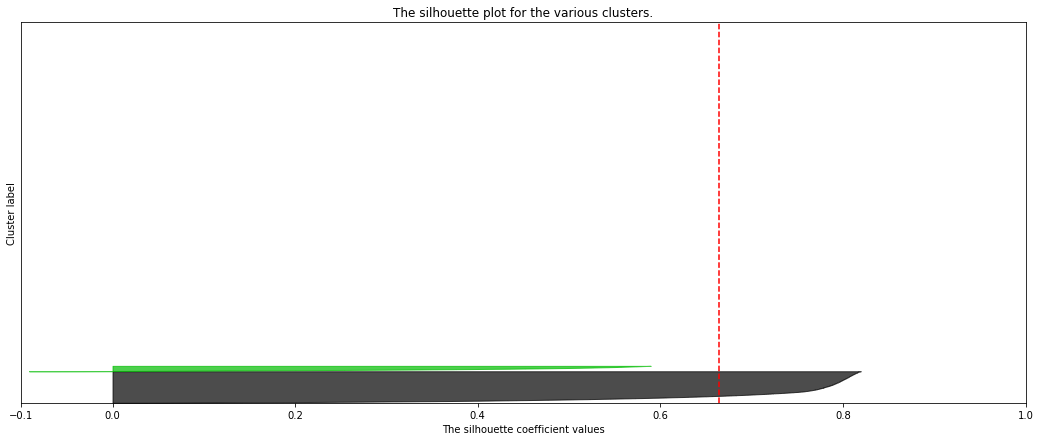

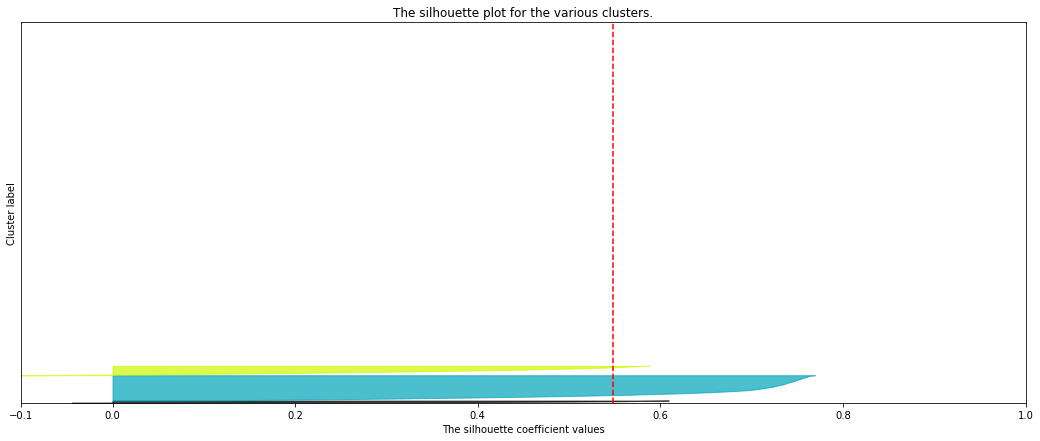

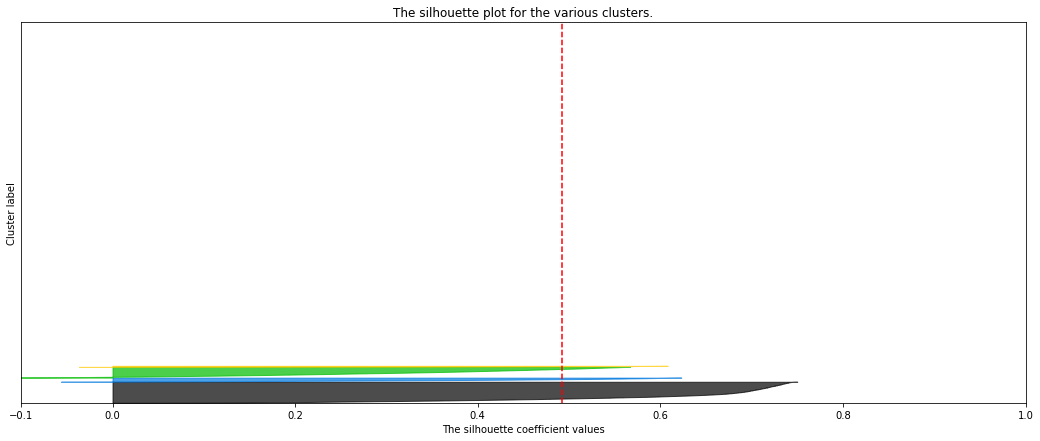

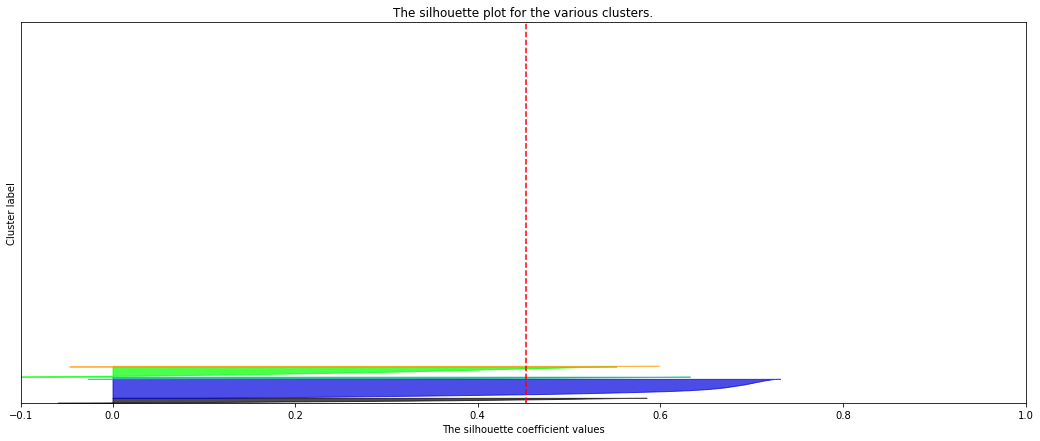

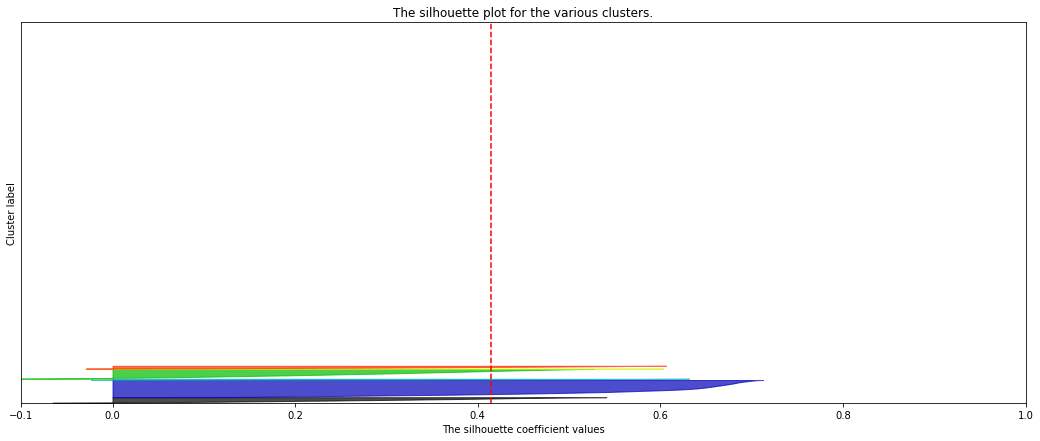

In [10]:
user_for_cluster = users[['user_orders','user_period','user_mean_days_since_prior','user_total_products','user_reorder_ratio','user_distinct_products','user_average_basket','days_since_prior_order']]
range_n_clusters = [2, 3, 4, 5, 6]
user_for_cluster_sam = user_for_cluster.sample(20000, random_state=1)

for n_clusters in range_n_clusters:
    # 建立具有1行2列的子圖
    plt.figure(figsize=(18, 7))

    # 第一個子圖是輪廓圖
    # 輪廓係數的範圍為-0.1、1   
    plt.xlim([-0.1, 1])

    # （n_clusters + 1）* 10用於在各個群集的輪廓圖之間插入空格，以明確劃分它們。
    plt.ylim([0, len(user_for_cluster) + (n_clusters + 1) * 10])

    # 使用n_clusters值和seed 10隨機初始集群。
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(user_for_cluster_sam)

    # Silhouette_score給出所有樣本的平均值。
    # 這可以透視形成的簇的密度和分離
    silhouette_avg = silhouette_score(user_for_cluster_sam, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # 計算每個樣本的輪廓分數
    sample_silhouette_values = silhouette_samples(user_for_cluster_sam, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # 彙總屬於聚類i的樣本的輪廓分數，並對它們進行排序
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = pltcm.nipy_spectral(float(i) / n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # 在輪廓圖的中間標註聚類編號


        # 下一個圖計算新的y_lower
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # 所有值的平均輪廓分數的垂直線
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    plt.yticks([])  # 清除y軸標籤/刻度
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

For n_clusters = 6 The average silhouette_score is : 0.41496470842134076


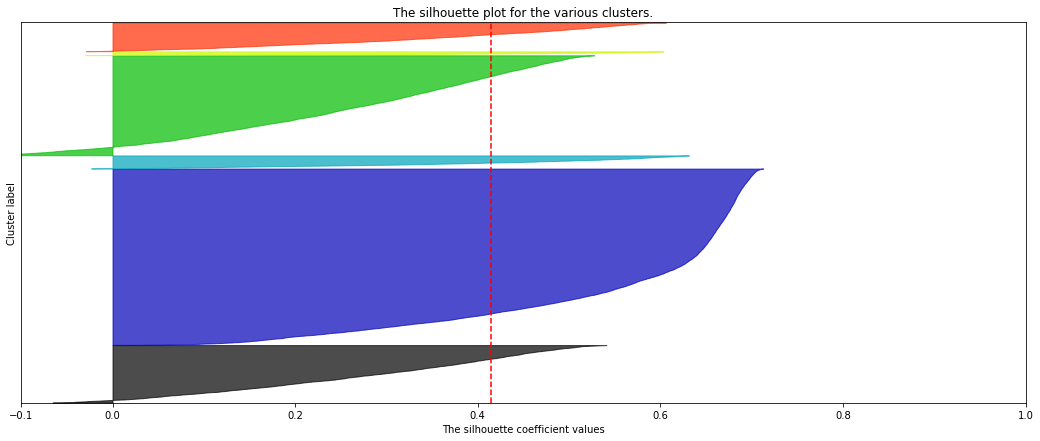

In [42]:
n_clusters = 6
plt.figure(figsize=(18, 7))

# 第一個子圖是輪廓圖
# 輪廓係數的範圍為-0.1、1   
plt.xlim([-0.1, 1])

# （n_clusters + 1）* 10用於在各個群集的輪廓圖之間插入空格，以明確劃分它們。
plt.ylim([0, len(user_for_cluster) + (n_clusters + 1) * 10])

# 使用n_clusters值和seed 10隨機初始集群。
clusterer = KMeans(n_clusters=n_clusters, random_state=10)
cluster_labels = clusterer.fit_predict(user_for_cluster_sam)

# Silhouette_score給出所有樣本的平均值。
# 這可以透視形成的簇的密度和分離
silhouette_avg = silhouette_score(user_for_cluster_sam, cluster_labels)
print("For n_clusters =", n_clusters,
      "The average silhouette_score is :", silhouette_avg)

# 計算每個樣本的輪廓分數
sample_silhouette_values = silhouette_samples(user_for_cluster_sam, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # 彙總屬於聚類i的樣本的輪廓分數，並對它們進行排序
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = pltcm.nipy_spectral(float(i) / n_clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # 在輪廓圖的中間標註聚類編號


    # 下一個圖計算新的y_lower
    y_lower = y_upper + 10  # 10 for the 0 samples

plt.title("The silhouette plot for the various clusters.")
plt.xlabel("The silhouette coefficient values")
plt.ylabel("Cluster label")

# 所有值的平均輪廓分數的垂直線
plt.axvline(x=silhouette_avg, color="red", linestyle="--")

plt.yticks([])  # 清除y軸標籤/刻度
plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

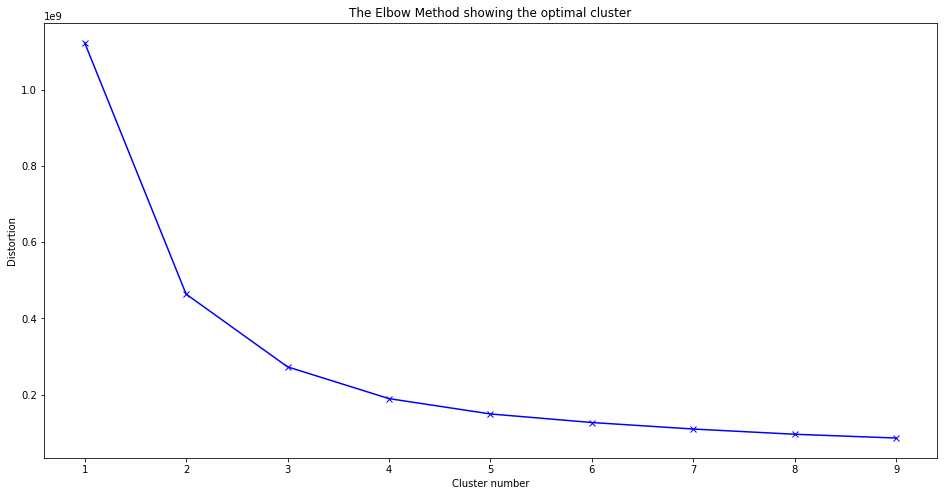

In [10]:
user_for_cluster = users[['user_orders','user_period','user_mean_days_since_prior','user_total_products','user_reorder_ratio','user_distinct_products','user_average_basket','days_since_prior_order']]
user_for_cluster_sam = user_for_cluster.sample(20000, random_state=1)
distortions = []
K = range(1,10)
for i in K:
    kmeanModel = KMeans(n_clusters=i)
    kmeanModel.fit(user_for_cluster_sam)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Cluster number')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal cluster')
plt.savefig('elbow_method.png')

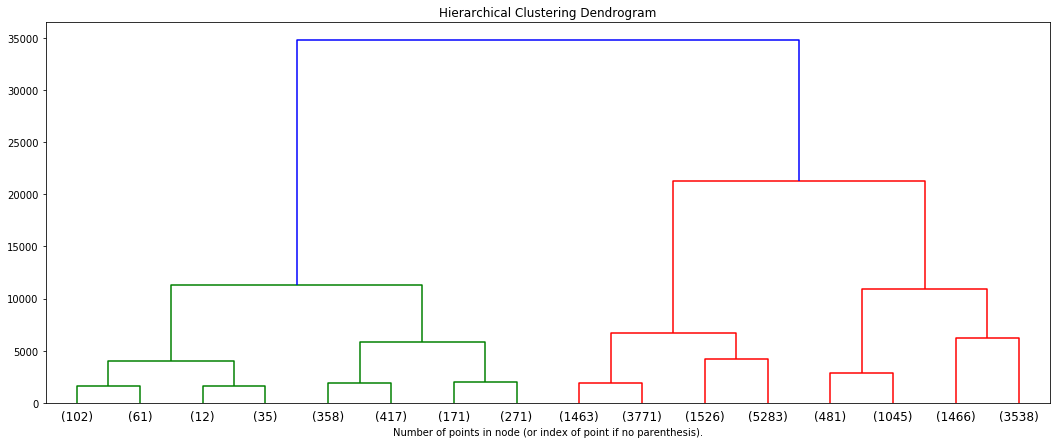

<Figure size 432x288 with 0 Axes>

In [35]:
user_for_cluster = users[['user_orders','user_period','user_mean_days_since_prior','user_total_products','user_reorder_ratio','user_distinct_products','user_average_basket','days_since_prior_order']]
#find the cluster number - hierarchical
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


X = user_for_cluster_sam

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.figure(figsize=(18, 7))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()
plt.savefig('hierarchical.png', dpi = 320, format= "png",bbox_inches='tight')

In [11]:
gc.collect()

13180

In [12]:
#clustering
user_for_cluster = users[['user_orders','user_period','user_mean_days_since_prior','user_total_products','user_reorder_ratio','user_distinct_products','user_average_basket','days_since_prior_order']]
clusterer = KMeans(n_clusters=3, random_state=10)
cluster_labels = clusterer.fit_predict(user_for_cluster)
users['cluster'] = cluster_labels

In [13]:
del us
gc.collect()

0

## user cluster features

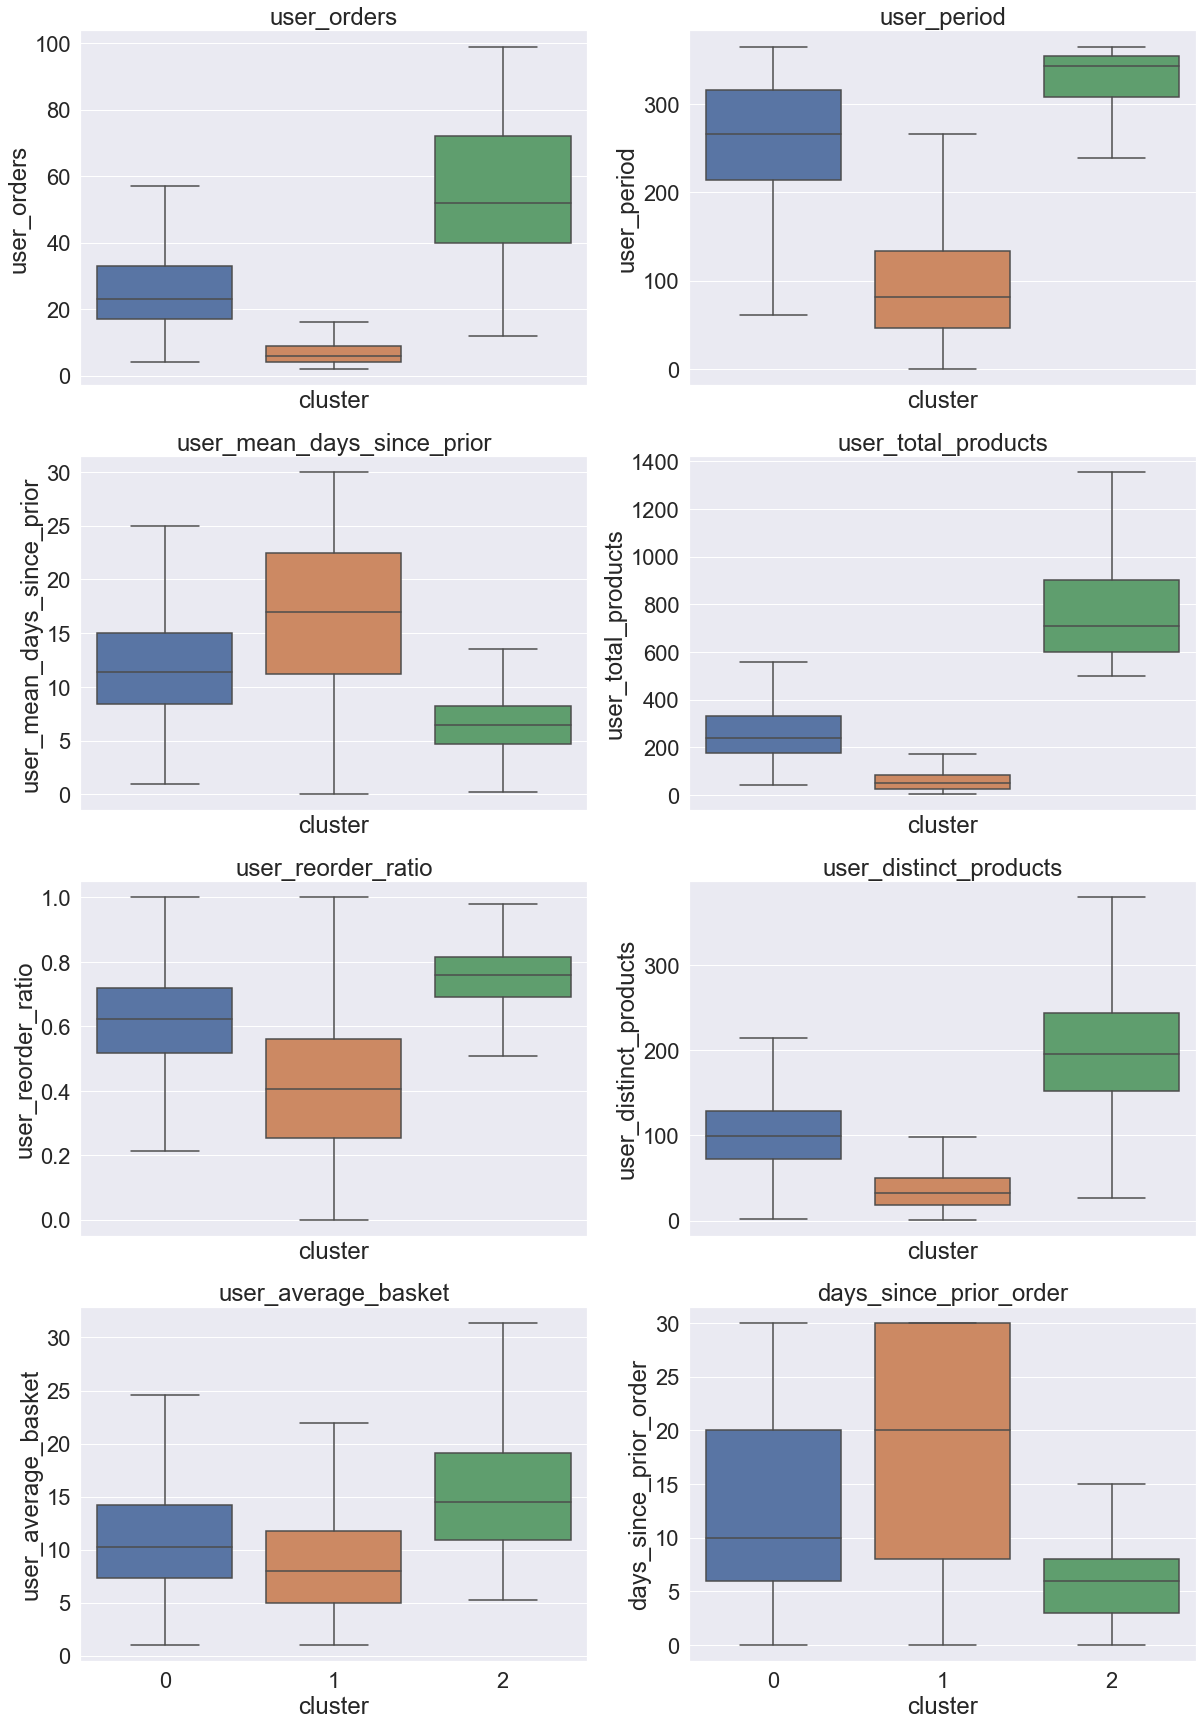

In [154]:
users_cl = ['user_orders','user_period','user_mean_days_since_prior','user_total_products','user_reorder_ratio','user_distinct_products','user_average_basket','days_since_prior_order']
fig, axes = plt.subplots(4, 2, sharex=True, figsize=(20,30))
for c in users_cl:
    #axes[int(users_cl.index(c)/2)][users_cl.index(c) %2].set_title(c)
    #sns.boxplot(x=users['cluster'], y=users[c], showfliers=False)
    sns.boxplot(x=users['cluster'], y=users[c], showfliers=False,ax=axes[int(users_cl.index(c)/2)][users_cl.index(c) %2]).set_title(c)

In [155]:
plt.savefig('boxplot_user.png')

<Figure size 432x288 with 0 Axes>

## user 變數選擇(要再把order_hour_of_day與order_dow拿掉前做)

In [13]:
corr = users.drop(['user_id','order_id'], axis=1).corr()

In [47]:
users['order_hour_of_day'] = users['order_hour_of_day'].apply(lambda x:aaa(x))
users['order_dow'] = users['order_dow'].apply(lambda x: aaa(x))

KeyError: 'order_hour_of_day'

In [ ]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=40,
    horizontalalignment='right'
)

In [ ]:
ax.figure.savefig('user_heatmap10051226.png',dpi=300, bbox_inches='tight')

## all data merge

In [41]:
data = orders_product.groupby(['user_id', 'product_id']).size().to_frame('up_orders') #每個combination的總數
data['up_first_order'] = orders_product.groupby(['user_id', 'product_id'])['order_number'].min() #每個combination的訂購順序
data['up_last_order'] = orders_product.groupby(['user_id', 'product_id'])['order_number'].max() #每個combination的訂購順序
data['up_average_cart_position'] = orders_product.groupby(['user_id', 'product_id'])['add_to_cart_order'].mean() #每個combination加入購物車的順序
data = data.reset_index()

In [42]:
#加入前面新增的product及user的特徵
data = data.merge(prd, on = 'product_id')
data = data.merge(users, on = 'user_id')

data['up_order_rate'] = data['up_orders'] / data['user_orders'] #消費者購買產品的集中度
data['up_orders_since_last_order'] = data['user_orders'] - data['up_last_order'] #距離該combination最近一次的訂購相隔多少次其他產品的訂購 

In [43]:
#加入train的訂購單
data = data.merge(train_orders[['user_id', 'product_id', 'reordered']], how = 'left', on = ['user_id', 'product_id'])
data = data.merge(product, on = 'product_id')

del orders_product
gc.collect()

28551

In [44]:
XGBdata = pd.concat([data, pd.get_dummies(data['eval_set'])], axis=1).drop(['eval_set','product_name'], axis=1)

In [45]:
XGBtrain = XGBdata[XGBdata['train'] == 1]
XGBtrain.drop(['train','our_test','user_id','product_id','order_id'], axis=1, inplace=True)
XGBtrain['reordered'].fillna(0, inplace=True)

XGBtest = XGBdata[XGBdata['our_test'] == 1]
test_id = XGBtest[['user_id','product_id']]
XGBtest.drop(['train','our_test','user_id','product_id','order_id','reordered'], axis=1, inplace=True)

c:\users\administrator\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
c:\users\administrator\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [57]:
unbalanced_value_1 = XGBtrain[XGBtrain['reordered'] == 1]['up_orders'].count()
unbalanced_value_0 = XGBtrain[XGBtrain['reordered'] == 0]['up_orders'].count()

In [63]:
unbalanced_XGBtrain = XGBtrain
unbalanced_XGBtrain.loc[unbalanced_XGBtrain['reordered'] == 1,'reordered'] = 'reordered'
unbalanced_XGBtrain.loc[unbalanced_XGBtrain['reordered'] == 0,'reordered'] = 'non-reordered'

C:\python3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [64]:
unbalanced_XGBtrain['reordered']

0               reordered
3           non-reordered
5           non-reordered
6           non-reordered
7               reordered
                ...      
12954554    non-reordered
12954555    non-reordered
12954557    non-reordered
12954558    non-reordered
12954560    non-reordered
Name: reordered, Length: 8455001, dtype: object

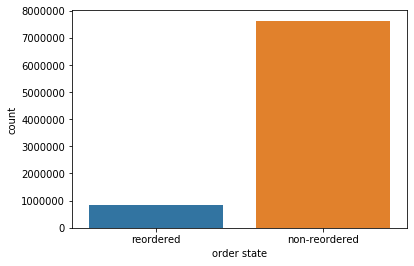

In [69]:
sns_count = sns.countplot(unbalanced_XGBtrain['reordered'])
sns_count.set(xlabel = 'order state')
sns_count.figure.savefig('unbalanced_reordered_nonreordered_count.png')

In [46]:
train_1 = XGBtrain[XGBtrain['reordered'] == 1].sample(n=round(len(XGBtrain)/2), replace=True, random_state=1)
train_0 = XGBtrain[XGBtrain['reordered'] == 0].sample(n=round(len(XGBtrain)/2), replace=True, random_state=1)

In [47]:
XGBtrain = pd.concat([train_1, train_0])

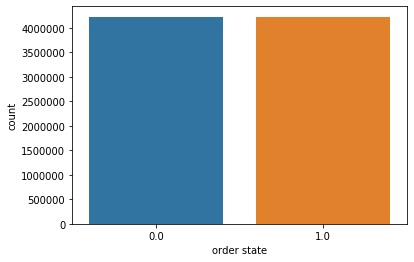

In [76]:
sns_count = sns.countplot(XGBtrain['reordered'])
sns_count.set(xlabel = 'order state')
sns_count.figure.savefig('balanced_reordered_nonreordered_count.png')

In [24]:
XGBtrain.to_csv('XGBtrain.csv',index=False)
XGBtest.to_csv('XGBtest.csv',index=False)

## XGBoost

In [48]:
XGBtrain = pd.read_csv('XGBtrain.csv')
XGBtest = pd.read_csv('XGBtest.csv')
ord_test = pd.read_csv('ord_prior_we_dont_want.csv')
orders =  pd.read_csv('orders_no_test.csv')

### regressor & binary

### XGBoost without choosing variables - regressor

In [49]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import plot_confusion_matrix

In [50]:
import xgboost as xgb
xg_reg = xgb.XGBRegressor(objective ='reg:logistic', colsample_bytree = 0.5, learning_rate = 0.05, max_depth = 5, 
                          alpha = 10, n_estimators = 200,tree_method='gpu_hist')

In [51]:
xgb_model = xg_reg.fit(XGBtrain.drop('reordered',axis=1),XGBtrain['reordered'])
preds = xg_reg.predict(XGBtest)

In [52]:
X=np.arange(0.65,0.85,0.01)
F1=[]#填入19個F1值
Accuracy=[]#填入19個Accuracy值

In [53]:
test_actual = pd.merge(ord_test, orders, how='left', on='order_id')
test_actual_all = test_actual.groupby(by=['user_id','product_id'], as_index=False).agg({'reordered':'max'})
test_name = test_id.reset_index()
test_name.drop('index', axis=1, inplace=True)

In [54]:
from sklearn.metrics import f1_score

In [55]:
for threshold in X:
    preds_df=pd.DataFrame(preds)
    preds_df.rename(columns={0:'pred_reordered'}, inplace=True)
    preds_df.loc[preds_df['pred_reordered'] >=threshold, 'pred_reordered'] = 1
    preds_df.loc[preds_df['pred_reordered'] < threshold, 'pred_reordered'] = 0
    pred_user_prod = pd.concat([test_name, preds_df], axis=1)
    test_user_to_valid = pd.merge(pred_user_prod, test_actual_all[test_actual_all['reordered'] == 1], how='left', on=['user_id', 'product_id'])
    test_user_to_valid.fillna(0, inplace=True)
    Accuracy.append(accuracy_score(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered']))
    F1.append(f1_score(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered'], average='macro'))

<Figure size 432x288 with 0 Axes>

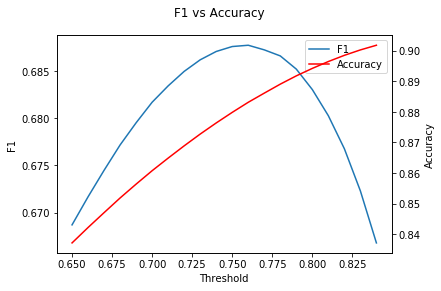

In [56]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111)
lns1 = ax.plot(X, F1, '-', label = 'F1')

ax2 = ax.twinx()
lns2 = ax2.plot(X, Accuracy, '-r', label = 'Accuracy')

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
ax.set_xlabel('Threshold')
ax.set_ylabel('F1')
ax2.set_ylabel('Accuracy')
plt.suptitle('F1 vs Accuracy', size=12)
plt.show()

In [87]:
ax.figure.savefig('f1 VS accuracy without choosing_XGBOOST.png',dpi=300, bbox_inches='tight')

In [57]:
threshold_data_XGB_without_choose = pd.DataFrame({
    'X':X,
    'f1':F1}).sort_values('f1',ascending=False)

In [ ]:
threshold_data_XGB_without_choose.to_csv('threshold_data_XGB_without_choose.csv')

In [58]:
threshold = 0.76
preds_df=pd.DataFrame(preds)
preds_df.rename(columns={0:'pred_reordered'}, inplace=True)
preds_df.loc[preds_df['pred_reordered'] >=threshold, 'pred_reordered'] = 1
preds_df.loc[preds_df['pred_reordered'] < threshold, 'pred_reordered'] = 0
pred_user_prod = pd.concat([test_name, preds_df], axis=1)
test_user_to_valid = pd.merge(pred_user_prod, test_actual_all[test_actual_all['reordered'] == 1], how='left', on=['user_id', 'product_id'])
test_user_to_valid.fillna(0, inplace=True)
Accuracy.append(accuracy_score(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered']))
F1.append(f1_score(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered'], average='macro'))

In [59]:
from sklearn.metrics import accuracy_score
accuracy_score(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered'])

0.8831550455700011

In [99]:
from sklearn.metrics import confusion_matrix as cm
array = cm(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered'])

In [100]:
array

array([[3766700,  275535],
       [ 250216,  207110]], dtype=int64)

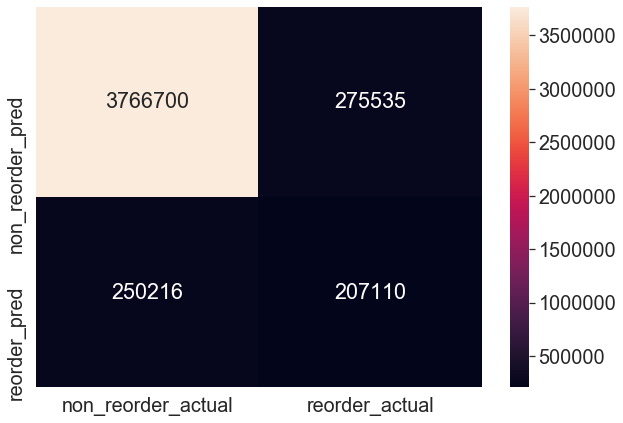

In [132]:
df_cm = pd.DataFrame(array, index = [i for i in ["non_reorder_pred",'reorder_pred']],
                  columns = [i for i in ["non_reorder_actual",'reorder_actual']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt="d")
sns.set(font_scale=2)

In [131]:
plt.savefig('confusion_matrix_regressor.png')

<Figure size 432x288 with 0 Axes>

In [32]:
from sklearn.metrics import confusion_matrix as cm
cm(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered'])
tn, fp, fn, tp = cm(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered']).ravel()
print(tp/(fp+tp)) #預測會回購的數量中，實際上會回購的比例
print(tp/(fn+tp)) #實際上會回購的數量中，預測會回購的比例
print(tn/(tn+fp)) #實際上不會回購的數量中，預測不會回購的比例
print(tn/(tn+fn)) #預測不會回購的數量中，實際上不會回購的比例

0.42912044792406495
0.45315376777178645
0.9317951578767687
0.9377369839631412


In [33]:
import numpy as np
from sklearn import metrics
y = test_user_to_valid['reordered']
pred =  test_user_to_valid['pred_reordered']
fpr, tpr, thresholds = metrics.roc_curve(y_true=y, y_score=pred, pos_label=1)
roc_auc  = metrics.auc(fpr, tpr)
roc_auc

0.6924744628242776

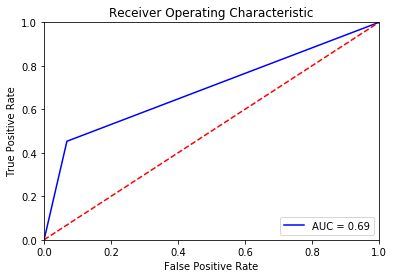

In [34]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

#plt.show()
plt.savefig('auc without choosing_XGBOOST.png',dpi=300,bbox_inches='tight')

### XGBoost without choosing variables - binary

In [133]:
gc.collect()

45002

In [134]:
import xgboost as xgb
xg_reg = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.5, learning_rate = 0.1, max_depth = 5, 
                          alpha = 10, n_estimators = 10,tree_method='gpu_hist')

In [135]:
xgb_model_binary = xg_reg.fit(XGBtrain.drop('reordered',axis=1),XGBtrain['reordered'])
preds = xg_reg.predict(XGBtest)

In [136]:
preds_df=pd.DataFrame(preds)
preds_df.rename(columns={0:'pred_reordered'}, inplace=True)
test_actual = pd.merge(ord_test, orders, how='left', on='order_id')
test_actual_all = test_actual.groupby(by=['user_id','product_id'], as_index=False).agg({'reordered':'max'})
test_name = test_id.reset_index()
test_name.drop('index', axis=1, inplace=True)
pred_user_prod = pd.concat([test_name, preds_df], axis=1)
test_user_to_valid = pd.merge(pred_user_prod, test_actual_all[test_actual_all['reordered'] == 1], how='left', on=['user_id', 'product_id'])
test_user_to_valid.fillna(0, inplace=True)

In [137]:
from sklearn.metrics import accuracy_score
accuracy_score(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered'])

0.7415430083068104

In [142]:
array=cm(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered'])

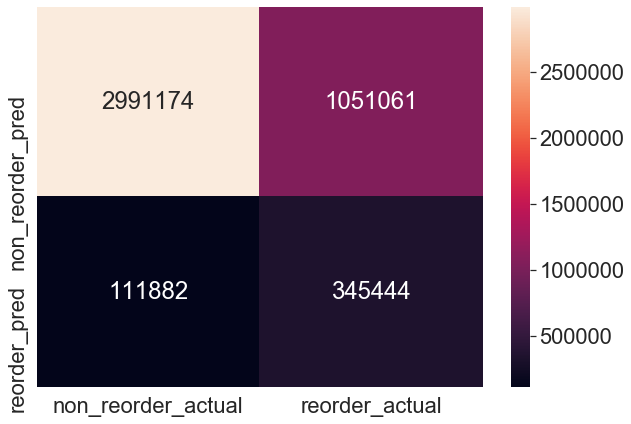

In [143]:
df_cm = pd.DataFrame(array, index = [i for i in ["non_reorder_pred",'reorder_pred']],
                  columns = [i for i in ["non_reorder_actual",'reorder_actual']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt="d")
sns.set(font_scale=2)

In [47]:
from sklearn.metrics import f1_score
f1_score(test_user_to_valid['reordered'],
         test_user_to_valid['pred_reordered'],
         average='macro')

0.6049623291716334

In [43]:
from sklearn.metrics import confusion_matrix as cm
cm(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered'])

array([[2991174, 1051061],
       [ 111882,  345444]], dtype=int64)

In [44]:
tn, fp, fn, tp = cm(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered']).ravel()
print(tp/(fp+tp)) #預測會回購的數量中，實際上會回購的比例
print(tp/(fn+tp)) #實際上會回購的數量中，預測會回購的比例
print(tn/(tn+fp)) #實際上不會回購的數量中，預測不會回購的比例
print(tn/(tn+fn)) #預測不會回購的數量中，實際上不會回購的比例

0.24736323894293252
0.7553561354482361
0.7399802337073426
0.9639445759277306


In [45]:
import numpy as np
from sklearn import metrics
y = test_user_to_valid['reordered']
pred =  test_user_to_valid['pred_reordered']
fpr, tpr, thresholds = metrics.roc_curve(y_true=y, y_score=pred, pos_label=1)
roc_auc  = metrics.auc(fpr, tpr)
roc_auc

0.7476681845777895

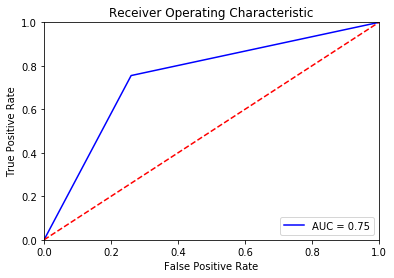

In [46]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.show()
plt.savefig('auc without choosing_XGBOOST_binary.png',dpi=300,bbox_inches='tight')

### XGBoost with choosing variables -regressor

In [32]:
import xgboost as xgb
xg_reg = xgb.XGBRegressor(objective ='reg:logistic', colsample_bytree = 0.5, learning_rate = 0.05, max_depth = 5, 
                          alpha = 10, n_estimators = 200,tree_method='gpu_hist')

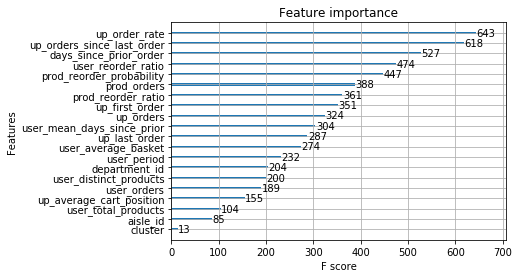

In [35]:
from xgboost import plot_importance
importance_plot = plot_importance(xgb_model)
importance_plot.figure.savefig('importance.png',dpi=300, bbox_inches='tight')

In [36]:
XGBtrain_ch = XGBtrain.drop(['cluster','aisle_id','user_total_products','up_average_cart_position','user_orders'], axis=1)
XGBtest_ch = XGBtest.drop(['cluster','aisle_id','user_total_products','up_average_cart_position','user_orders'], axis=1)

In [37]:
xgb_model = xg_reg.fit(XGBtrain_ch.drop('reordered',axis=1),XGBtrain['reordered'])
preds = xg_reg.predict(XGBtest_ch)

In [38]:
X=np.arange(0.65,0.85,0.01)
F1=[]#填入19個F1值
Accuracy=[]#填入19個Accuracy值

In [39]:
test_actual = pd.merge(ord_test, orders, how='left', on='order_id')
test_actual_all = test_actual.groupby(by=['user_id','product_id'], as_index=False).agg({'reordered':'max'})
test_name = test_id.reset_index()
test_name.drop('index', axis=1, inplace=True)

In [40]:
from sklearn.metrics import f1_score

In [41]:
for threshold in X:
    preds_df=pd.DataFrame(preds)
    preds_df.rename(columns={0:'pred_reordered'}, inplace=True)
    preds_df.loc[preds_df['pred_reordered'] >=threshold, 'pred_reordered'] = 1
    preds_df.loc[preds_df['pred_reordered'] < threshold, 'pred_reordered'] = 0
    pred_user_prod = pd.concat([test_name, preds_df], axis=1)
    test_user_to_valid = pd.merge(pred_user_prod, test_actual_all[test_actual_all['reordered'] == 1], how='left', on=['user_id', 'product_id'])
    test_user_to_valid.fillna(0, inplace=True)
    Accuracy.append(accuracy_score(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered']))
    F1.append(f1_score(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered'], average='macro'))

<Figure size 432x288 with 0 Axes>

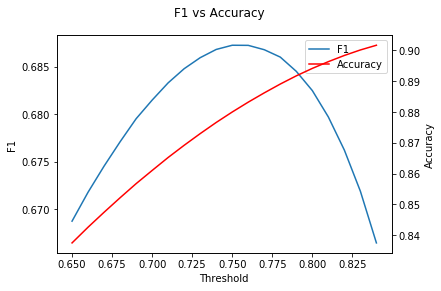

In [42]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111)
lns1 = ax.plot(X, F1, '-', label = 'F1')

ax2 = ax.twinx()
lns2 = ax2.plot(X, Accuracy, '-r', label = 'Accuracy')

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
ax.set_xlabel('Threshold')
ax.set_ylabel('F1')
ax2.set_ylabel('Accuracy')
plt.suptitle('F1 vs Accuracy', size=12)
plt.show()

In [43]:
ax.figure.savefig('f1 VS accuracy with choosing_XGBOOST.png',dpi=300, bbox_inches='tight')

In [44]:
threshold_data_XGB_with_choose=pd.DataFrame({
    'X':X,
    'f1':F1}).sort_values('f1',ascending=False)

,X,f1
10,0.75,0.687266
11,0.76,0.687254
9,0.74,0.686823
12,0.77,0.686795
13,0.78,0.686015
8,0.73,0.685956
7,0.72,0.684794
14,0.79,0.684512
6,0.71,0.683302
15,0.80,0.682486


In [ ]:
threshold_data_XGB_with_choose.to_csv('threshold_data_XGB_with_choose.csv')

In [45]:
pd.DataFrame({
    'X':X,
    'ACC':Accuracy}).sort_values('ACC',ascending=False)

,X,ACC
19,0.84,0.901651
18,0.83,0.900122
17,0.82,0.898337
16,0.81,0.896323
15,0.80,0.894137
14,0.79,0.891718
13,0.78,0.889057
12,0.77,0.886192
11,0.76,0.883180
10,0.75,0.879976


### XGBoost with choosing variables - binary

In [ ]:
import xgboost as xgb
xg_reg = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.5, learning_rate = 0.1, max_depth = 5, 
                          alpha = 10, n_estimators = 10,tree_method='gpu_hist')

In [ ]:
from xgboost import plot_importance
importance_plot = plot_importance(xgb_model_binary)
importance_plot.figure.savefig('importance.png',dpi=300, bbox_inches='tight')

In [ ]:
XGBtrain_ch = XGBtrain.drop(['cluster','aisle_id','user_total_products','up_average_cart_position','user_orders'], axis=1)
XGBtest_ch = XGBtest.drop(['cluster','aisle_id','user_total_products','up_average_cart_position','user_orders'], axis=1)

In [ ]:
xgb_model_binary = xg_reg.fit(XGBtrain_ch.drop('reordered',axis=1),XGBtrain_ch['reordered'])
preds = xg_reg.predict(XGBtest_ch)

In [ ]:
preds_df=pd.DataFrame(preds)
preds_df.rename(columns={0:'pred_reordered'}, inplace=True)
test_actual = pd.merge(ord_test, orders, how='left', on='order_id')
test_actual_all = test_actual.groupby(by=['user_id','product_id'], as_index=False).agg({'reordered':'max'})
test_name = test_id.reset_index()
test_name.drop('index', axis=1, inplace=True)
pred_user_prod = pd.concat([test_name, preds_df], axis=1)
test_user_to_valid = pd.merge(pred_user_prod, test_actual_all[test_actual_all['reordered'] == 1], how='left', on=['user_id', 'product_id'])
test_user_to_valid.fillna(0, inplace=True)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered'])

In [ ]:
from sklearn.metrics import confusion_matrix as cm
cm(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered'])

In [ ]:
tn, fp, fn, tp = cm(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered']).ravel()
print(tp/(fp+tp)) #預測會回購的數量中，實際上會回購的比例
print(tp/(fn+tp)) #實際上會回購的數量中，預測會回購的比例
print(tn/(tn+fp)) #實際上不會回購的數量中，預測不會回購的比例
print(tn/(tn+fn)) #預測不會回購的數量中，實際上不會回購的比例

In [ ]:
import numpy as np
from sklearn import metrics
y = test_user_to_valid['reordered']
pred =  test_user_to_valid['pred_reordered']
fpr, tpr, thresholds = metrics.roc_curve(y_true=y, y_score=pred, pos_label=1)
roc_auc  = metrics.auc(fpr, tpr)
roc_auc

In [ ]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.show()
plt.savefig('days_since_prior_order.png',dpi=300,bbox_inches='tight')

### XGBoost result

In [46]:
threshold = 0.75

In [47]:
preds_df=pd.DataFrame(preds)
preds_df.rename(columns={0:'pred_reordered'}, inplace=True)
preds_df.loc[preds_df['pred_reordered'] >=threshold, 'pred_reordered'] = 1
preds_df.loc[preds_df['pred_reordered'] < threshold, 'pred_reordered'] = 0
pred_user_prod = pd.concat([test_name, preds_df], axis=1)
test_user_to_valid = pd.merge(pred_user_prod, test_actual_all[test_actual_all['reordered'] == 1], how='left', on=['user_id', 'product_id'])
test_user_to_valid.fillna(0, inplace=True)

In [48]:
cm(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered'])

array([[3745808,  296427],
       [ 243629,  213697]], dtype=int64)

In [49]:
from sklearn.metrics import accuracy_score
accuracy_score(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered'])

0.879975846532584

In [50]:
tn, fp, fn, tp = cm(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered']).ravel()
print(tp/(fp+tp)) #預測會回購的數量中，實際上會回購的比例
print(tp/(fn+tp)) #實際上會回購的數量中，預測會回購的比例
print(tn/(tn+fp)) #實際上不會回購的數量中，預測不會回購的比例
print(tn/(tn+fn)) #預測不會回購的數量中，實際上不會回購的比例

0.41891187240749306
0.4672749854589505
0.9266675490168187
0.9389314833145629


In [51]:
import numpy as np
from sklearn import metrics
y = test_user_to_valid['reordered']
pred =  test_user_to_valid['pred_reordered']
fpr, tpr, thresholds = metrics.roc_curve(y_true=y, y_score=pred, pos_label=1)
roc_auc  = metrics.auc(fpr, tpr)
roc_auc

0.6969712672378846

In [52]:
fpr

array([0.        , 0.07333245, 1.        ])

In [53]:
tpr

array([0.        , 0.46727499, 1.        ])

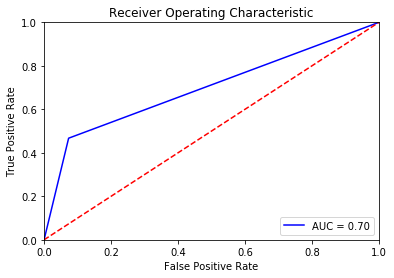

In [63]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.show()
plt.savefig('days_since_prior_order.png',dpi=300,bbox_inches='tight')

## Light gbm

### binary

In [23]:
import lightgbm 

In [24]:
model = lightgbm.LGBMClassifier(boosting_type='gbdt', objective='binary', num_leaves=50,
                                learning_rate=0.1, n_estimators=10, max_depth=5,
                                bagging_fraction=0.9, feature_fraction=0.9, reg_lambda=0.2)

model.fit(XGBtrain.drop('reordered',axis=1),XGBtrain['reordered'])
preds = model.predict(XGBtest)
preds_df=pd.DataFrame(preds)
preds_df.rename(columns={0:'pred_reordered'}, inplace=True)
test_actual = pd.merge(ord_test, orders, how='left', on='order_id')
test_actual_all = test_actual.groupby(by=['user_id','product_id'], as_index=False).agg({'reordered':'max'})
test_name = test_id.reset_index()
test_name.drop('index', axis=1, inplace=True)
pred_user_prod = pd.concat([test_name, preds_df], axis=1)
test_user_to_valid = pd.merge(pred_user_prod, test_actual_all[test_actual_all['reordered'] == 1], how='left', on=['user_id', 'product_id'])
test_user_to_valid.fillna(0, inplace=True)

In [25]:
from sklearn.metrics import accuracy_score
accuracy_score(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered'])

0.7359049027227322

In [26]:
from sklearn.metrics import f1_score
f1_score(test_user_to_valid['reordered'],
         test_user_to_valid['pred_reordered'],
         average='macro')

0.601664768480492

In [27]:
from sklearn.metrics import confusion_matrix as cm
cm(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered'])

array([[2961666, 1080569],
       [ 107743,  349583]], dtype=int64)

In [28]:
tn, fp, fn, tp = cm(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered']).ravel()
print(tp/(fp+tp)) #預測會回購的數量中，實際上會回購的比例
print(tp/(fn+tp)) #實際上會回購的數量中，預測會回購的比例
print(tn/(tn+fp)) #實際上不會回購的數量中，預測不會回購的比例
print(tn/(tn+fn)) #預測不會回購的數量中，實際上不會回購的比例

0.2444376541794159
0.7644065721170457
0.7326803117582229
0.9648978028017772


In [29]:
import numpy as np
from sklearn import metrics
y = test_user_to_valid['reordered']
pred =  test_user_to_valid['pred_reordered']
fpr, tpr, thresholds = metrics.roc_curve(y_true=y, y_score=pred, pos_label=1)
roc_auc =metrics.auc(fpr, tpr)

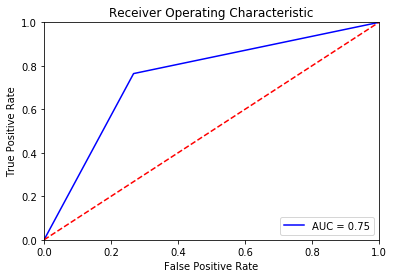

In [30]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.show()
plt.savefig('AUC_lightgbm_class.png',dpi=300,bbox_inches='tight')

### regressor

In [96]:
model = lightgbm.LGBMRegressor(boosting_type='gbdt', objective='regression', num_leaves=50,
                                learning_rate=0.1, n_estimators=10, max_depth=5,
                                bagging_fraction=0.9, feature_fraction=0.9, reg_lambda=0.2)

model.fit(XGBtrain.drop('reordered',axis=1),XGBtrain['reordered'])
preds = model.predict(XGBtest)

In [97]:
X=np.arange(0.45,0.85,0.01)
F1=[]#填入19個F1值
Accuracy=[]#填入19個Accuracy值

In [98]:
for threshold in X:
    preds_df=pd.DataFrame(preds)
    preds_df.rename(columns={0:'pred_reordered'}, inplace=True)
    preds_df.loc[preds_df['pred_reordered'] >=threshold, 'pred_reordered'] = 1
    preds_df.loc[preds_df['pred_reordered'] < threshold, 'pred_reordered'] = 0
    pred_user_prod = pd.concat([test_name, preds_df], axis=1)
    test_user_to_valid = pd.merge(pred_user_prod, test_actual_all[test_actual_all['reordered'] == 1], how='left', on=['user_id', 'product_id'])
    test_user_to_valid.fillna(0, inplace=True)
    Accuracy.append(accuracy_score(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered']))
    F1.append(f1_score(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered'], average='macro'))

<Figure size 432x288 with 0 Axes>

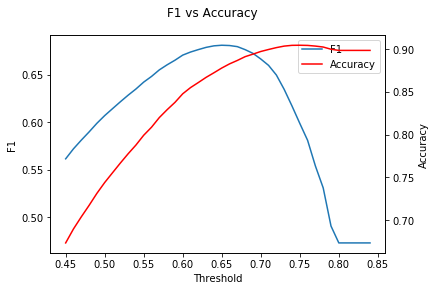

In [99]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111)
lns1 = ax.plot(X, F1, '-', label = 'F1')

ax2 = ax.twinx()
lns2 = ax2.plot(X, Accuracy, '-r', label = 'Accuracy')

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
ax.set_xlabel('Threshold')
ax.set_ylabel('F1')
ax2.set_ylabel('Accuracy')
plt.suptitle('F1 vs Accuracy', size=12)
plt.show()

In [100]:
ax.figure.savefig('f1 VS accuracy with choosing_Lightgbm.png',dpi=300, bbox_inches='tight')

In [101]:
pd.DataFrame({
    'X':X,
    'f1':F1}).sort_values('f1',ascending=False)

,X,f1
20,0.65,0.680875
21,0.66,0.680573
19,0.64,0.680247
22,0.67,0.679414
18,0.63,0.678647
17,0.62,0.676302
23,0.68,0.676236
16,0.61,0.673741
24,0.69,0.672357
15,0.60,0.670515


In [102]:
pd.DataFrame({
    'X':X,
    'ACC':Accuracy}).sort_values('ACC',ascending=False)

,X,ACC
30,0.75,0.904390
29,0.74,0.904276
31,0.76,0.904191
32,0.77,0.903411
28,0.73,0.903386
33,0.78,0.902304
27,0.72,0.901624
34,0.79,0.899725
26,0.71,0.899444
39,0.84,0.898362


In [103]:
threshold = 0.65
preds_df=pd.DataFrame(preds)
preds_df.rename(columns={0:'pred_reordered'}, inplace=True)
preds_df.loc[preds_df['pred_reordered'] >=threshold, 'pred_reordered'] = 1
preds_df.loc[preds_df['pred_reordered'] < threshold, 'pred_reordered'] = 0
pred_user_prod = pd.concat([test_name, preds_df], axis=1)
test_user_to_valid = pd.merge(pred_user_prod, test_actual_all[test_actual_all['reordered'] == 1], how='left', on=['user_id', 'product_id'])
test_user_to_valid.fillna(0, inplace=True)

In [104]:
from sklearn.metrics import accuracy_score
accuracy_score(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered'])

0.8777667421332881

In [105]:
from sklearn.metrics import confusion_matrix as cm
cm(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered'])

array([[3741932,  300303],
       [ 249693,  207633]], dtype=int64)

In [106]:
tn, fp, fn, tp = cm(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered']).ravel()
print(tp/(fp+tp)) #預測會回購的數量中，實際上會回購的比例
print(tp/(fn+tp)) #實際上會回購的數量中，預測會回購的比例
print(tn/(tn+fp)) #實際上不會回購的數量中，預測不會回購的比例
print(tn/(tn+fn)) #預測不會回購的數量中，實際上不會回購的比例

0.40877787752787753
0.4540152976213904
0.9257086735432255
0.9374457770957944


In [107]:
import numpy as np
from sklearn import metrics
y = test_user_to_valid['reordered']
pred =  test_user_to_valid['pred_reordered']
fpr, tpr, thresholds = metrics.roc_curve(y_true=y, y_score=pred, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

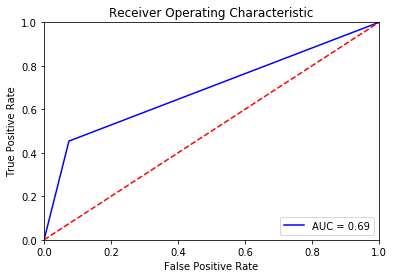

In [108]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.show()
plt.savefig('AUC_lightgbm.png',dpi=300,bbox_inches='tight')

## RandomForest

### binary

In [31]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100,n_jobs = -1, max_depth=2, random_state=0, verbose=True, min_samples_leaf = 10)
rf.fit(XGBtrain.drop('reordered',axis=1),XGBtrain['reordered'])
preds = rf.predict(XGBtest)
preds_df=pd.DataFrame(preds)
preds_df.rename(columns={0:'pred_reordered'}, inplace=True)
test_actual = pd.merge(ord_test, orders, how='left', on='order_id')
test_actual_all = test_actual.groupby(by=['user_id','product_id'], as_index=False).agg({'reordered':'max'})
test_name = test_id.reset_index()
test_name.drop('index', axis=1, inplace=True)
pred_user_prod = pd.concat([test_name, preds_df], axis=1)
test_user_to_valid = pd.merge(pred_user_prod, test_actual_all[test_actual_all['reordered'] == 1], how='left', on=['user_id', 'product_id'])
test_user_to_valid.fillna(0, inplace=True)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    3.2s finished


In [32]:
from sklearn.metrics import accuracy_score
accuracy_score(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered'])

0.7264235333180281

In [33]:
from sklearn.metrics import f1_score
f1_score(test_user_to_valid['reordered'],
         test_user_to_valid['pred_reordered'],
         average='macro')

0.5907111753037373

In [34]:
from sklearn.metrics import confusion_matrix as cm
cm(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered'])

array([[2929786, 1112449],
       [ 118525,  338801]], dtype=int64)

In [35]:
tn, fp, fn, tp = cm(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered']).ravel()
print(tp/(fp+tp)) #預測會回購的數量中，實際上會回購的比例
print(tp/(fn+tp)) #實際上會回購的數量中，預測會回購的比例
print(tn/(tn+fp)) #實際上不會回購的數量中，預測不會回購的比例
print(tn/(tn+fn)) #預測不會回購的數量中，實際上不會回購的比例

0.23345460809646856
0.7408303923240752
0.7247935857267082
0.9611178124541755


In [36]:
import numpy as np
from sklearn import metrics
y = test_user_to_valid['reordered']
pred =  test_user_to_valid['pred_reordered']
fpr, tpr, thresholds = metrics.roc_curve(y_true=y, y_score=pred, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

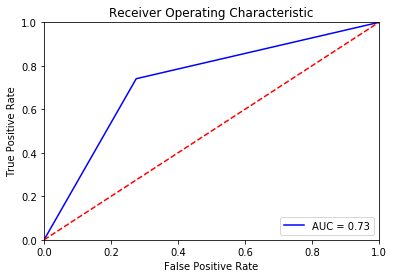

In [37]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.show()
plt.savefig('AUC_RF_classfier.png',dpi=300,bbox_inches='tight')

### regressor

In [79]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100,criterion='mse', n_jobs = -1, max_depth=2, random_state=0, verbose=True, min_samples_leaf = 10)
rf.fit(XGBtrain.drop('reordered',axis=1),XGBtrain['reordered'])
preds = rf.predict(XGBtest)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.8min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    1.4s finished


In [80]:
test_actual = pd.merge(ord_test, orders, how='left', on='order_id')
test_actual_all = test_actual.groupby(by=['user_id','product_id'], as_index=False).agg({'reordered':'max'})
test_name = test_id.reset_index()
test_name.drop('index', axis=1, inplace=True)

In [81]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import accuracy_score

In [82]:
X=np.arange(0.65,0.85,0.01)
F1=[]#填入19個F1值
Accuracy=[]#填入19個Accuracy值

In [83]:
for threshold in X:
    preds_df=pd.DataFrame(preds)
    preds_df.rename(columns={0:'pred_reordered'}, inplace=True)
    preds_df.loc[preds_df['pred_reordered'] >=threshold, 'pred_reordered'] = 1
    preds_df.loc[preds_df['pred_reordered'] < threshold, 'pred_reordered'] = 0
    pred_user_prod = pd.concat([test_name, preds_df], axis=1)
    test_user_to_valid = pd.merge(pred_user_prod, test_actual_all[test_actual_all['reordered'] == 1], how='left', on=['user_id', 'product_id'])
    test_user_to_valid.fillna(0, inplace=True)
    Accuracy.append(accuracy_score(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered']))
    F1.append(f1_score(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered'], average='macro'))

In [84]:
pd.DataFrame({
    'X':X,
    'f1':F1}).sort_values('f1',ascending=False)

,X,f1
0,0.65,0.648104
8,0.73,0.648104
14,0.79,0.648104
13,0.78,0.648104
12,0.77,0.648104
11,0.76,0.648104
1,0.66,0.648104
9,0.74,0.648104
10,0.75,0.648104
7,0.72,0.648104


<Figure size 432x288 with 0 Axes>

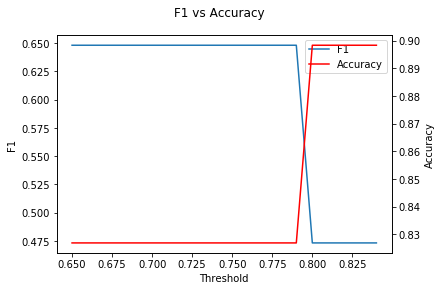

In [86]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111)
lns1 = ax.plot(X, F1, '-', label = 'F1')

ax2 = ax.twinx()
lns2 = ax2.plot(X, Accuracy, '-r', label = 'Accuracy')

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
ax.set_xlabel('Threshold')
ax.set_ylabel('F1')
ax2.set_ylabel('Accuracy')
plt.suptitle('F1 vs Accuracy', size=12)
plt.show()

In [87]:
ax.figure.savefig('f1 VS accuracy with choosing_RF.png',dpi=300, bbox_inches='tight')

In [88]:
preds_df=pd.DataFrame(preds)
preds_df.rename(columns={0:'pred_reordered'}, inplace=True)
preds_df.loc[preds_df['pred_reordered'] >=14, 'pred_reordered'] = 1
preds_df.loc[preds_df['pred_reordered'] < 14, 'pred_reordered'] = 0
pred_user_prod = pd.concat([test_name, preds_df], axis=1)
test_user_to_valid = pd.merge(pred_user_prod, test_actual_all[test_actual_all['reordered'] == 1], how='left', on=['user_id', 'product_id'])
test_user_to_valid.fillna(0, inplace=True)

In [89]:
cm(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered'])

array([[4042235,       0],
       [ 457326,       0]], dtype=int64)

In [90]:
tn, fp, fn, tp = cm(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered']).ravel()
print(tp/(fp+tp)) #預測會回購的數量中，實際上會回購的比例
print(tp/(fn+tp)) #實際上會回購的數量中，預測會回購的比例
print(tn/(tn+fp)) #實際上不會回購的數量中，預測不會回購的比例
print(tn/(tn+fn)) #預測不會回購的數量中，實際上不會回購的比例

nan
0.0
1.0
0.8983620846567032


c:\users\administrator\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in longlong_scalars
  


In [93]:
import numpy as np
from sklearn import metrics
y = test_user_to_valid['reordered']
pred =  test_user_to_valid['pred_reordered']
fpr, tpr, thresholds = metrics.roc_curve(y_true=y, y_score=pred, pos_label=1)
roc_auc =metrics.auc(fpr, tpr)

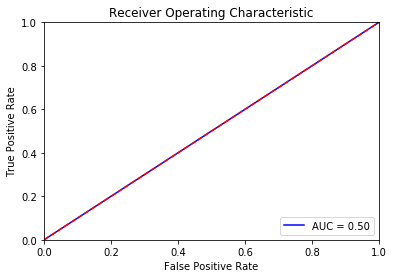

In [94]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.show()
plt.savefig('AUC_RF.png',dpi=300,bbox_inches='tight')

### Logistic regression

In [48]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(random_state=0).fit(XGBtrain.drop('reordered',axis=1),XGBtrain['reordered'])
preds = LR.predict(XGBtest)
preds_df=pd.DataFrame(preds)
preds_df.rename(columns={0:'pred_reordered'}, inplace=True)
test_actual = pd.merge(ord_test, orders, how='left', on='order_id')
test_actual_all = test_actual.groupby(by=['user_id','product_id'], as_index=False).agg({'reordered':'max'})
test_name = test_id.reset_index()
test_name.drop('index', axis=1, inplace=True)
pred_user_prod = pd.concat([test_name, preds_df], axis=1)
test_user_to_valid = pd.merge(pred_user_prod, test_actual_all[test_actual_all['reordered'] == 1], how='left', on=['user_id', 'product_id'])
test_user_to_valid.fillna(0, inplace=True)

c:\users\administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [49]:
from sklearn.metrics import accuracy_score
accuracy_score(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered'])

0.6284190835505953

In [50]:
from sklearn.metrics import f1_score
f1_score(test_user_to_valid['reordered'],
         test_user_to_valid['pred_reordered'],
         average='macro')

0.5276082500654696

In [51]:
from sklearn.metrics import confusion_matrix as cm
cm(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered'])

array([[2453109, 1589126],
       [  82825,  374501]], dtype=int64)

In [52]:
tn, fp, fn, tp = cm(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered']).ravel()
print(tp/(fp+tp)) #預測會回購的數量中，實際上會回購的比例
print(tp/(fn+tp)) #實際上會回購的數量中，預測會回購的比例
print(tn/(tn+fp)) #實際上不會回購的數量中，預測不會回購的比例
print(tn/(tn+fn)) #預測不會回購的數量中，實際上不會回購的比例

0.19071901129898908
0.8188928685445394
0.6068694670151538
0.9673394496859934


In [53]:
import numpy as np
from sklearn import metrics
y = test_user_to_valid['reordered']
pred =  test_user_to_valid['pred_reordered']
fpr, tpr, thresholds = metrics.roc_curve(y_true=y, y_score=pred, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

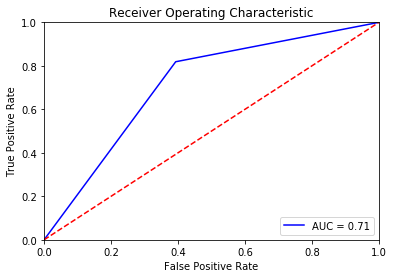

In [54]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.show()
plt.savefig('AUC_LR_classfier.png',dpi=300,bbox_inches='tight')

### SVM

In [ ]:
from sklearn import svm
SVM = svm.SVC(kernel='linear')
SVM = SVM.fit(XGBtrain.drop('reordered',axis=1),XGBtrain['reordered'])
preds = SVM.predict(XGBtest)
preds_df=pd.DataFrame(preds)
preds_df.rename(columns={0:'pred_reordered'}, inplace=True)
test_actual = pd.merge(ord_test, orders, how='left', on='order_id')
test_actual_all = test_actual.groupby(by=['user_id','product_id'], as_index=False).agg({'reordered':'max'})
test_name = test_id.reset_index()
test_name.drop('index', axis=1, inplace=True)
pred_user_prod = pd.concat([test_name, preds_df], axis=1)
test_user_to_valid = pd.merge(pred_user_prod, test_actual_all[test_actual_all['reordered'] == 1], how='left', on=['user_id', 'product_id'])
test_user_to_valid.fillna(0, inplace=True)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered'])

In [ ]:
from sklearn.metrics import f1_score
f1_score(test_user_to_valid['reordered'],
         test_user_to_valid['pred_reordered'],
         average='macro')

In [ ]:
from sklearn.metrics import confusion_matrix as cm
cm(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered'])

In [ ]:
from sklearn import metrics
y = test_user_to_valid['reordered']
pred =  test_user_to_valid['pred_reordered']
fpr, tpr, thresholds = metrics.roc_curve(y_true=y, y_score=pred, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.show()
plt.savefig('AUC_DT_classfier.png',dpi=300,bbox_inches='tight')

### Decision trees

In [55]:
from sklearn import tree
DT = tree.DecisionTreeClassifier()
DT = DT.fit(XGBtrain.drop('reordered',axis=1),XGBtrain['reordered'])
preds = DT.predict(XGBtest)
preds_df=pd.DataFrame(preds)
preds_df.rename(columns={0:'pred_reordered'}, inplace=True)
test_actual = pd.merge(ord_test, orders, how='left', on='order_id')
test_actual_all = test_actual.groupby(by=['user_id','product_id'], as_index=False).agg({'reordered':'max'})
test_name = test_id.reset_index()
test_name.drop('index', axis=1, inplace=True)
pred_user_prod = pd.concat([test_name, preds_df], axis=1)
test_user_to_valid = pd.merge(pred_user_prod, test_actual_all[test_actual_all['reordered'] == 1], how='left', on=['user_id', 'product_id'])
test_user_to_valid.fillna(0, inplace=True)

In [56]:
from sklearn.metrics import accuracy_score
accuracy_score(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered'])

0.8037661896349444

In [57]:
from sklearn.metrics import f1_score
f1_score(test_user_to_valid['reordered'],
         test_user_to_valid['pred_reordered'],
         average='macro')

0.5916355391295246

In [58]:
from sklearn.metrics import confusion_matrix as cm
cm(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered'])

array([[3429801,  612434],
       [ 270532,  186794]], dtype=int64)

In [59]:
tn, fp, fn, tp = cm(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered']).ravel()
print(tp/(fp+tp)) #預測會回購的數量中，實際上會回購的比例
print(tp/(fn+tp)) #實際上會回購的數量中，預測會回購的比例
print(tn/(tn+fp)) #實際上不會回購的數量中，預測不會回購的比例
print(tn/(tn+fn)) #預測不會回購的數量中，實際上不會回購的比例

0.23371803790657986
0.4084482404236803
0.8484912430870546
0.9268898231591589


In [60]:
from sklearn import metrics
y = test_user_to_valid['reordered']
pred =  test_user_to_valid['pred_reordered']
fpr, tpr, thresholds = metrics.roc_curve(y_true=y, y_score=pred, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

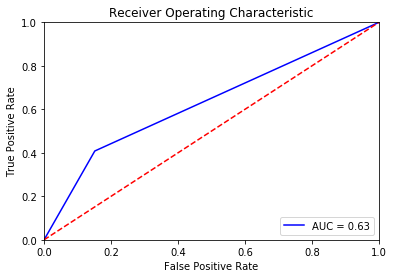

In [62]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.show()
plt.savefig('AUC_DT_classfier.png',dpi=300,bbox_inches='tight')

### KNN

In [67]:
from sklearn.neighbors import NearestCentroid
KNN = NearestCentroid()
KNN.fit(XGBtrain.drop('reordered',axis=1),XGBtrain['reordered'])
NearestCentroid()
preds = KNN.predict(XGBtest)
preds_df=pd.DataFrame(preds)
preds_df.rename(columns={0:'pred_reordered'}, inplace=True)
test_actual = pd.merge(ord_test, orders, how='left', on='order_id')
test_actual_all = test_actual.groupby(by=['user_id','product_id'], as_index=False).agg({'reordered':'max'})
test_name = test_id.reset_index()
test_name.drop('index', axis=1, inplace=True)
pred_user_prod = pd.concat([test_name, preds_df], axis=1)
test_user_to_valid = pd.merge(pred_user_prod, test_actual_all[test_actual_all['reordered'] == 1], how='left', on=['user_id', 'product_id'])
test_user_to_valid.fillna(0, inplace=True)

In [68]:
from sklearn.metrics import accuracy_score
accuracy_score(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered'])

0.7908471515332274

In [69]:
from sklearn.metrics import f1_score
f1_score(test_user_to_valid['reordered'],
         test_user_to_valid['pred_reordered'],
         average='macro')

0.5462562624715261

In [70]:
from sklearn.metrics import confusion_matrix as cm
cm(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered'])

array([[3431023,  611212],
       [ 329884,  127442]], dtype=int64)

In [71]:
tn, fp, fn, tp = cm(test_user_to_valid['reordered'], test_user_to_valid['pred_reordered']).ravel()
print(tp/(fp+tp)) #預測會回購的數量中，實際上會回購的比例
print(tp/(fn+tp)) #實際上會回購的數量中，預測會回購的比例
print(tn/(tn+fp)) #實際上不會回購的數量中，預測不會回購的比例
print(tn/(tn+fn)) #預測不會回購的數量中，實際上不會回購的比例

0.17253274198745286
0.27866773373917075
0.8487935510924031
0.9122860522740924


In [72]:
from sklearn import metrics
y = test_user_to_valid['reordered']
pred =  test_user_to_valid['pred_reordered']
fpr, tpr, thresholds = metrics.roc_curve(y_true=y, y_score=pred, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

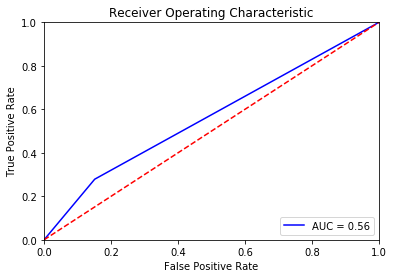

In [73]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.show()
plt.savefig('AUC_KNN_classfier.png',dpi=300,bbox_inches='tight')

In [74]:
gc.collect()

2419